# Large-Scale modeling and analysis of TCR-pMHC

#### I) VDJ -> fasta + clustering
#### II) Run TCRpMHC models on real + negative
#### III) Calculate on Rosetta + FoldX energies
#### IV) Statistics
#### V) Model Quality 

First task to do:
VDJdb -> look complete TCR (paired), check scores, download data
IMGT -> download TCR V, D, J genes and transform to fasta format 

VDJdb calculates scores in range 0 to 3 where:
0 - critical information missing, 1 - medium confidence, 2 - high confidence, 3 - very high confidence.

Initially, python structures such as dicts were used to generate the sequences. But afterwards I used pandas, much faster!

ftp://ftp.ebi.ac.uk/pub/databases/ipd/mhc/

In [1]:
import re

infile=open('SearchTable-2020-02-06 14_18_56.611.tsv','r')
#outfile=open('fastaFile_output.txt','w')
#output1=""
speciesCount=[]
complexID=""
TCR=dict()
TR=dict()
VgeneCheck=None
JgeneCheck=None
for line in infile:
    if "\t\t" in line:
        line.replace("\t\t","\t-\t")
        #print(line)
    
    
    if line[0:1].isdigit()==True:
    
        line1=line.split("\t")
        complexID=line1[0]
        TRAlist=""
        TRBlist=""
        #The TR lists is composed by Specie(5), Vgene, Jgene, CDR3, MHC-A, MHC-B, Epitope

        
        VgeneCheck=re.search("TR[AB]V\w+",line1[3])
        JgeneCheck=re.search("TR[AB]J\w+",line1[4])
        
        #if Vgene is not None:
        #if complexID=="13":
        #    print(line1[3])
        spModified=line1[5].lower()
        
        #if VgeneCheck and JgeneCheck is not None:        
        totlist=[]
        if line1[1]=="TRA":
            TRAlist=[spModified,line1[3],line1[4],line1[2],line1[6],line1[7],line1[9]] 
            TR["TRA"]=TRAlist
            #TCR[complexID]={"TRA":TRAlist}
            
            #if complexID=="13":
             #   print(TRAlist)
            
            #need to add it here, otherwise the values are not correct
        elif line1[1]=="TRB":
            TRBlist=[spModified,line1[3],line1[4],line1[2],line1[6],line1[7],line1[9]] 
            TR["TRB"]=TRBlist
            
        
        TCR[complexID]=TR
            #{"TRA":TRAlist,"TRB":TRBlist}
        
        #if line1[5] not in speciesCount:
        #    speciesCount+=line1[5]
        #    print(speciesCount)
        
#for i in TCR.keys():
#    if len(TCR[i].keys())!=2:
#        print(len(TCR[i].keys()))
    
#print(TCR["13"])

len(TCR)




21311

### Pandas DF are much easier and faser, I only need to run this!

In [3]:
import pandas as pd
import re

infile='SearchTable-2020-02-06 14_18_56.611.tsv'
df=pd.read_table(infile, sep="\t")
infile2='Jgenes_fasta_outfile'
df2=pd.read_table(infile2, sep="|",names=["Name", "Specie","Funct","0", "1","2","3","4","5","6","7","8","9","10","Seq"])
infile3='Vgenes_fasta_outfile.txt'
df3=pd.read_table(infile3, sep="|",names=["Name", "Specie","Funct","0", "1","2","3","4","5","6","7","8","9","10","Seq"])


In [4]:
df.loc[df["complex.id"]==23720]

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
506,23720,TRA,CAEYTGTASKLTF,TRAV5*01,TRAJ44*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,NLVPMVATV,pp65,CMV,PMID:16237109,"{""frequency"": ""3/3"", ""identification"": ""tetram...","{""cell.subset"": ""CD8+"", ""clone.id"": ""3.1"", ""do...","{""cdr3"": ""CAEYTGTASKLTF"", ""cdr3_old"": ""CAEYTGT...",1
41984,23720,TRB,CACSLRSQGTDTQYF,TRBV30*01,NaN,HomoSapiens,HLA-A*02:01,B2M,MHCI,NLVPMVATV,pp65,CMV,PMID:16237109,"{""frequency"": ""3/3"", ""identification"": ""tetram...","{""cell.subset"": ""CD8+"", ""clone.id"": ""3.1"", ""do...","{""cdr3"": ""CACSLRSQGTDTQYF"", ""cdr3_old"": ""CACSL...",1


In [5]:
df4=df3.iloc[:,[0,1,14]]
sp1=df3["Specie"]
sp1
#df4[(df4["Name"]==VgeneA & df4["Specie"]==specie)].iloc[0,1]

>IMGT000049    Bos taurus_Hereford
>IMGT000049    Bos taurus_Hereford
>IMGT000049    Bos taurus_Hereford
>IMGT000049    Bos taurus_Hereford
>IMGT000049    Bos taurus_Hereford
                      ...         
>JH481615       Tursiops truncatus
>JH481615       Tursiops truncatus
>JH481615       Tursiops truncatus
>JH473572       Tursiops truncatus
>JH473572       Tursiops truncatus
Name: Specie, Length: 1023, dtype: object

## Statistics/Correlations 

In [6]:
#First drop N/A
df=df.dropna()

#Then remove the un-paired complex.id 
complex_id_list = list(set(df['complex.id']))
drops=[]
for i in complex_id_list:
    i=int(i)
    if len(df.loc[df["complex.id"]==i])!=2:
        drops.append(i)
        #df.drop(df.index[df.loc[df["complex.id"]==i].index[0]])
        
        #df.drop(df.index[i])


In [541]:
df = df[~df["complex.id"].isin(drops)]
mhcII=list(df.loc[df["MHC class"]=="MHCII", "complex.id"])
df = df[~df["complex.id"].isin(mhcII)]

In [544]:
#There are 21292 Vgenes in Alpha 
#and 21267 in Beta, and 25 that are not paired
#len(VgenesDFB["V"])+len(drops)
print(len(df.loc[df["Gene"]=="TRA"]))
len(df.loc[df["Gene"]=="TRB"])

21203


21203

In [545]:
dfAlpha=df[(df['Gene']=='TRA')].iloc[:,[0,1,3,4,5,9]]
VgenesDFA=dfAlpha.iloc[:,[2,3,4]]
newA = VgenesDFA["J"].copy()
df6A=VgenesDFA["V"].str.cat(newA, sep ="")
alphaVJ=df6A.value_counts()


dfBeta=df[(df['Gene']=='TRB')].iloc[:,[0,1,3,4,5,9]]
VgenesDFB=dfBeta.iloc[:,[2,3,4]]
newB = VgenesDFB["J"].copy()
#VgenesBeta=
df6B=VgenesDFB["V"].str.cat(newB, sep ="")
betaVJ=df6B.value_counts()

VgenesBeta=VgenesDFB["V"].copy().unique()
VgenesAlpha=VgenesDFA["V"].copy().unique()
VgenesAB=VgenesDFA["V"].str.cat(VgenesDFB["V"], sep="")
VgenesAB_counts=VgenesAB.value_counts()

result = pd.concat([alphaVJ, betaVJ], axis=1, sort=False)
#result.dropna()
alpha=dfVJA.iloc[:,[0,2]]
beta=dfVJB.iloc[:,[0,2]]
#pd.concat([alpha,beta], axis=complex.id)


/Users/s182286/opt/anaconda3/envs/myclone/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: A future version of pandas will perform index alignment when `others` is a Series/Index/DataFrame (or a list-like containing one). To disable alignment (the behavior before v.0.23) and silence this warning, use `.values` on any Series/Index/DataFrame in `others`. To enable alignment and silence this warning, pass `join='left'|'outer'|'inner'|'right'`. The future default will be `join='left'`.


In [546]:
#But this is actually to construct the ones that I have, not the combinations
VJ=dict()

for row in range(0,len(VgenesDFA)-1):
    outDict=dict()
    outer_key=VgenesDFB["V"].iloc[row]
    inner_key=VgenesDFB["J"].iloc[row]
    
    if outer_key not in VJ.keys():
        outDict[inner_key]=1
        VJ[outer_key]=outDict
    else:
        if inner_key not in outDict.keys():
            outDict[inner_key]=1
        else:
            outDict[inner_key]+=1
        VJ[outer_key]=outDict
print(len(VJ))

55


### Heatmap of V vs J genes in Alpha or in Beta

The data will be normalized with KL divergence (https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810)

array(['HomoSapiens'], dtype=object)

In [547]:
JgenesAlpha=newA.unique()
VgenesAlpha=VgenesDFA["V"].copy().unique()
count=0
geneCount=dict()
myDict=dict()
GenesV=[]
GenesJ=[]
Counts=[]
maxnum=int(alphaVJ.max())
VAcounts=VgenesDFA["V"].copy().value_counts()
JAcounts=VgenesDFA["J"].copy().value_counts()

def kl_divergence(P, Q):
    return np.sum(np.where(P != 0, P * np.log(P / Q), 0))

for V in VgenesAlpha:
    geneCount=dict()
    for J in JgenesAlpha:
        
        value=0
        concat=V+J
        if concat not in alphaVJ.keys():
            geneCount[J]=0
            myDict[V]=geneCount
            #Counts.append(0)
        else:
            
            P=(alphaVJ[concat]/tot)
            Pa=VAcounts[V]/tot
            Pb=JAcounts[J]/tot
            Q=(Pa*Pb)
            p+=P
            q+=Q
            value=kl_divergence(P,Q)
            
            geneCount[J]=value
            myDict[V]=geneCount
            
            #Counts.append(value) 
        #GenesV.append(V)
        #GenesJ.append(J)
data_VJalpha=pd.DataFrame.from_dict(myDict)

In [550]:
myDict

{'TRAV12-2*01': {'TRAJ24*02': 4.810761913574857e-05,
  'TRAJ54*01': -0.00018212382414384607,
  'TRAJ52*01': -0.00037975555662857853,
  'TRAJ42*01': -0.0005509203652268352,
  'TRAJ34*01': -0.00013573828230146283,
  'TRAJ6*01': 0.0005087566653406213,
  'TRAJ37*01': -0.0007700276033422242,
  'TRAJ13*01': 0.0004056098740528524,
  'TRAJ49*01': 0.00027945267835669554,
  'TRAJ14*01': 0.00020943974613117983,
  'TRAJ10*01': 0.0005988408604591775,
  'TRAJ31*01': 0.00198383221709423,
  'TRAJ12*01': 3.752285302984863e-05,
  'TRAJ28*01': -0.00036386177402281046,
  'TRAJ45*01': 0.002350977461957374,
  'TRAJ21*01': -0.0001663234558409108,
  'TRAJ33*01': -0.0007952591790405149,
  'TRAJ22*01': -0.00032932037500348364,
  'TRAJ40*01': -0.0007189671597526736,
  'TRAJ43*01': 7.333199852529264e-05,
  'TRAJ41*01': 0.00023260344340230094,
  'TRAJ30*01': 0.00203984664585456,
  'TRAJ39*01': -0.0007568616665194226,
  'TRAJ44*01': -0.00028478484574188733,
  'TRAJ29*01': -0.00010742100632956598,
  'TRAJ3*01': 0.00

AxesSubplot(0.125,0.125;0.62x0.755)


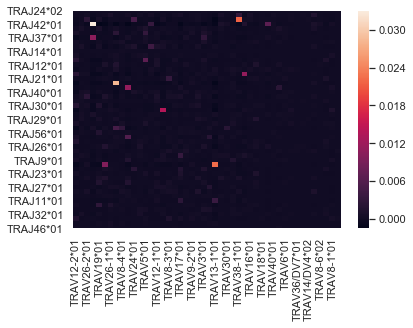

In [551]:
import seaborn as sns
print(sns.heatmap(data_VJalpha))

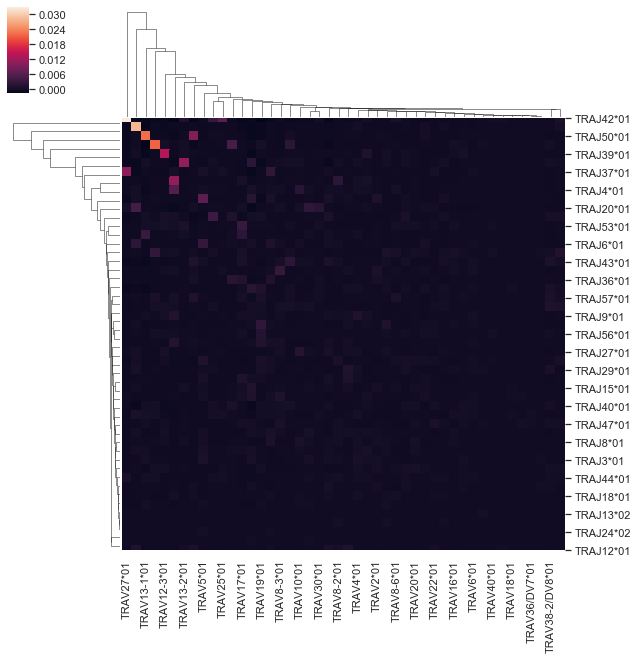

In [552]:
sns.clustermap(data_VJalpha)

### Heatmap of Vgenes in alpha vs Vgenes in beta

In [557]:

count=0
geneCount=dict()
myDict_AB_Vgenes=dict()
GenesV=[]
GenesJ=[]
Counts=[]
tot=VgenesAB_counts.sum()
Acounts=VgenesDFA["V"].copy().value_counts()
Bcounts=VgenesDFB["V"].copy().value_counts()
p=[]
q=[]

def kl_divergence(P, Q):
    return np.sum(np.where(P != 0, P * np.log(P / Q), 0))

for V1 in VgenesAlpha:
    geneCount=dict()
    for V2 in VgenesBeta:
        value=0
        concat=V1+V2
        if concat not in VgenesAB_counts.keys():
            geneCount[V2]=0
            myDict_AB_Vgenes[V1]=geneCount
            #Counts.append(0)x
        else:
            
            P=(VgenesAB_counts[concat]/tot)
            Pa=Acounts[V1]/tot
            Pb=Bcounts[V2]/tot
            Q=(Pa*Pb)
            p.append(P)
            q.append(Q)
            value=kl_divergence(P,Q)
            #value=VgenesAB_counts[concat]
            geneCount[V2]=value
            myDict_AB_Vgenes[V1]=geneCount
            
data_1=pd.DataFrame.from_dict(myDict_AB_Vgenes)
#data_1.sort_values('index')
d=data_1.corr()
#sns.heatmap(data_1)

In [558]:
myDict_AB_Vgenes

{'TRAV12-2*01': {'TRBV14*01': 2.8816344956506302e-05,
  'TRBV20-1*01': -0.0003703727246564834,
  'TRBV6-1*01': -0.0003049312700096275,
  'TRBV9*01': -0.0004341539078107042,
  'TRBV6-2*01': 0.00016457930746027375,
  'TRBV29-1*01': -0.0003857136339040266,
  'TRBV6-5*01': 0.00010404243924666804,
  'TRBV2*01': -6.781850477569625e-05,
  'TRBV19*01': 0.0016651849851236258,
  'TRBV7-2*01': 0.00029614822126223855,
  'TRBV11-2*01': 0.00037993222280230014,
  'TRBV6-9*01': 0,
  'TRBV24-1*01': -0.00029956151719455265,
  'TRBV5-1*01': -0.0001966264864130111,
  'TRBV12-3*01': 0.0005025298373973221,
  'TRBV5-5*01': -0.00018470093305004062,
  'TRBV16*01': -3.142518095792297e-05,
  'TRBV30*01': 1.929826730255726e-05,
  'TRBV6-4*01': 0.0003208272465267433,
  'TRBV7-3*01': 8.737345877375578e-05,
  'TRBV7-8*01': -0.00022785459579256726,
  'TRBV10-3*01': -5.129636945372361e-05,
  'TRBV7-9*01': -0.0005768489073600567,
  'TRBV9*02': 0,
  'TRBV12-4*01': -0.00011300555272867311,
  'TRBV4-1*01': 0.0002435982497

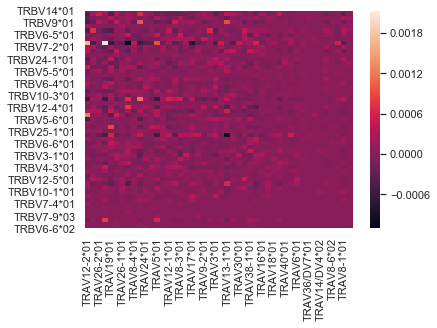

In [555]:
sns.heatmap(data_1)

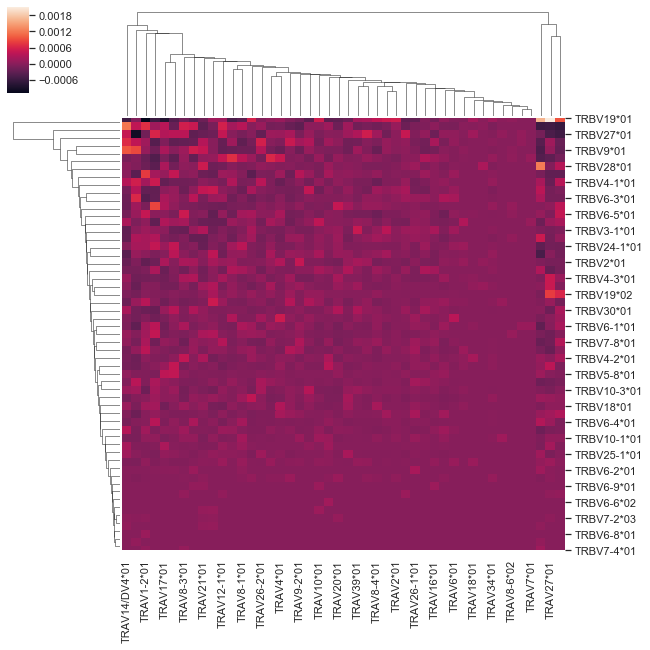

In [559]:
sns.clustermap(data_1)

How often are V and J genes together for each gene (to compare them, probably need to remove TRA and TRB from the beginning)


In [74]:
dict1=dict()
betaIndex=[]
data_betaVJ=[]
for PairName in alphaVJ.iteritems():
    splitted=PairName[0].split("TRA"); pair_name=splitted[1]+"+"+splitted[2]
    dict1={pair_name:PairName[1]}
    data_betaVJ.append(PairName[1])
    betaIndex.append(pair_name)
    #print(dict1)
Beta2=pd.DataFrame(data_betaVJ,index=betaIndex, columns=["Beta"])
#print(Beta2)

dict2=dict()
alphaIndex=[]
data_alphaVJ=[]
for PairName in betaVJ.iteritems():
    splitted=PairName[0].split("TRB"); pair_name=splitted[1]+"+"+splitted[2]
    dict2={pair_name:PairName[1]}
    data_alphaVJ.append(PairName[1])
    alphaIndex.append(pair_name)
    #print(dict2)    
Alpha2=pd.DataFrame(data_alphaVJ,index=alphaIndex, columns=["Alpha"])
#print(Alpha2)

dfAB=pd.concat([Alpha2,Beta2],axis=1,sort=False)

Now I will generate the data to put in the dataframe

In [47]:
complex_list_alpha = list(set(alpha['complex.id']))
complex_list_beta=list(set(beta['complex.id']))
#To create a list with both alpha and beta are present
list1 = complex_list_alpha
list2 = complex_list_beta
list_both = [item for item in list1 if item in list2]

data_alpha=[]
data_beta=[]
for iii in list_both:
    data_alpha.append(alpha.loc[alpha['complex.id']==iii,'V'].iloc[0])
    data_beta.append(beta.loc[beta['complex.id']==iii,'V'].iloc[0])


### IMGT/Gene-DB contains the V genes. The genes are downloaded and V genes are until the position before the Cystein!

In [561]:
import re

infile=open('Vgenes_fasta.txt','r')
outfile=open('Vgenes_fasta_outfile.txt','w')
header=""
line1=""
finalVgene=""

#This will put gene in a line called line1 to make it easier
for line in infile:
    if line.startswith(">"):
        
        
        if len(line1)>0:
            #print(line1[:104])
            lastChar=line1[:104]
            
            #Check for Functional V genes only and the entries that finish with the Cystein
            if headerTest[3]=="F" and lastChar[-1]=="C":
            
                final_Vgene=lastChar.replace(".","")
                print(header + final_Vgene, file=outfile)     
                #print(header + final_Vgene)
                #print(header)
            line1=""
            header=line.strip()

        else:
            headerTest=line[:-1].split("|")
            header=line.strip() 
            
            
    else:
        
        line1+=line.strip()


To put the J genes in the same line

In [562]:
import re

infile=open('Jgenes_fasta.txt','r')
outfile=open('Jgenes_fasta_outfile','w')
outfile2=open('JgenesAnalysis','w')
header=""
Jgene=""
for line in infile:
    
    if line.startswith('>'):
        if len(header)>0:
            result=re.search("\w+[FW](G.G\w+)$",Jgene)
            if result is not None:
                Jgene_processed=result.group(1)
                print(header +  Jgene_processed, file=outfile)
                #print(Jgene_processed, file=outfile2)
            header=""
            Jgene=""
            header=line.strip()
        else:
            header=line.strip()
    else:    
        Jgene=line.strip()


J-gene

### To create a dict for Jgenes and sequences

In [563]:

infile=open('Jgenes_fasta_outfile','r')

JgenesDict=dict()
spCount=[]
gnCount=[]
Species=dict()
for line in infile:
    line1=line.split("|")
    gene=line1[1]
    specie=line1[2].split("_")[0].lower().replace(" ","")
    sequence=line1[-1].strip()
    
    if specie not in spCount:
        spCount.append(specie)
    if specie not in gnCount:
        gnCount.append(gene)
    
    Species=dict()
    if specie not in JgenesDict.keys():
        if gene not in Species.keys():
            Species[gene]=sequence
            JgenesDict[specie]=Species
        else:
            continue
    else:
        if gene not in Species.keys():
            #Species[gene]=sequence
            JgenesDict[specie][gene]=sequence
        else:
            continue

infile.close()



In [564]:
JgenesDict

{'bostaurus': {'TRAJ1*01': 'GKGTRVSITP',
  'TRAJ10*01': 'GKGTVLLVFP',
  'TRAJ11*01': 'GSGTRLLVRP',
  'TRAJ13*01': 'GSGTMLKVNL',
  'TRAJ14*01': 'GEGTRLIVKL',
  'TRAJ15*01': 'GRGTRLTVQP',
  'TRAJ16*01': 'GSGTTVTVRA',
  'TRAJ17*01': 'GSGTKLRVKP',
  'TRAJ18*01': 'GSGTQLTVVP',
  'TRAJ19*01': 'GQGTELSVKP',
  'TRAJ2*01': 'GKGTQVSIIS',
  'TRAJ20*01': 'GAGTRVVVTP',
  'TRAJ21*01': 'GKGTRLLVKP',
  'TRAJ22*01': 'GDGTALTVKP',
  'TRAJ23*01': 'GKGTKLLVTP',
  'TRAJ24*01': 'GKGTRLAVTP',
  'TRAJ25*01': 'GRGTQLHVLP',
  'TRAJ26*01': 'GTGTQVVVKP',
  'TRAJ27*01': 'GTGTLLSVKP',
  'TRAJ28*01': 'GSGTKLIIKP',
  'TRAJ29*01': 'GAGTRLQVFP',
  'TRAJ3*01': 'GAGTRLSVHP',
  'TRAJ31*01': 'GQGTMLQVKP',
  'TRAJ32*01': 'GLGTSLAVNP',
  'TRAJ33*01': 'GGGTRLMVKP',
  'TRAJ34*01': 'GAGTRLQVLT',
  'TRAJ35*01': 'GQGTSVLVTP',
  'TRAJ36*01': 'GKGTMVSVKP',
  'TRAJ37*01': 'GAGTRLTVKP',
  'TRAJ38*01': 'GTGTRLQVTL',
  'TRAJ39*01': 'GKGTQLIIQP',
  'TRAJ4*01': 'GTGTRLTVHS',
  'TRAJ40*01': 'GTGTRLAVRP',
  'TRAJ41*01': 'GTGTRLTITA',
  'TR

### To create a dict for Vgenes and sequences

In [565]:


infile=open('Vgenes_fasta_outfile.txt','r')

VgenesDict=dict()
spCount=[]
gnCount=[]
Species=dict()

for line in infile:
    
    line1=line.split("|")
    gene=line1[1]
    specie=line1[2].split("_")[0].lower().replace(" ","")
    sequence=line1[-1].strip()
    
    if specie not in spCount:
        spCount.append(specie)
    if gene not in gnCount:
        gnCount.append(gene)

    #"""
    Species=dict()
    if specie not in VgenesDict.keys():
        if gene not in Species.keys():
            Species[gene]=sequence
            VgenesDict[specie]=Species
        else:
            continue
    else:
        if gene not in Species.keys():
            #Species[gene]=sequence
            VgenesDict[specie][gene]=sequence
        else:
            continue
    
    #"""       
infile.close()

 


In [566]:
VgenesDict

{'bostaurus': {'TRAV1*01': 'GKGVKQPTELMAIEGASAQVNCTYQTSGFNGLFWYQQHDGGAPVFLSYNVLDGLETRGHFSSFLRRSDAHSYLLLKELHMKDFASYLC',
  'TRAV10-2*01': 'KNQVEQNPPSLVVLEGENCTFQCNYTVSPFKLRWYTQDTGRGLVSLITMTYSDNKKSNGQYTATVDATAKHSSLHLTAAQLSDPAFYLC',
  'TRAV10-3*01': 'KNQVEQSPPSLVVLEGENCTFQSNYTVRPFNNLRWYTQDTGRGLVSLITMTYSDNKKSNGRYTATLVVTSKHSSLHLTAAQLSNPAFYIC',
  'TRAV11-1*01': 'QYTLDQSPSFLSIQERTHADLNCTYQKKTFYNFVWFKQEPGKGLVSLSLIQSSQKEEADKNFKELLGKEKVYSVLHISASHPGDSATYFC',
  'TRAV12-1*01': 'QNTVEQSPASLPVPEGAAASLGCTYSDSSSQYFAWYRQYPGKGPEFLLYVYANNNKEEGKFTAQSNKTNKHVSLRIRDSEPSDSATYLC',
  'TRAV12-3*01': 'QNTVEQSPASLPVPEGAAASLSCTYSDSNSQYFTWYRQYPGKGPEFLLQVYANNNKEEGKFTVQSNKTNKHVSLRIRDSEPSDSATYLC',
  'TRAV13-1*01': 'GNKVEQSPTLSVQEGNSSVITCTYTDGNSAYFPWYKQEPGKGPQFLIAIRSNKGKEEDQRLTVLLNKTTKRLSLHITTTEAGDSAVYFC',
  'TRAV13-4*01': 'GNKVEQSPTLSVQEGNSTFITCTYTDGNSNYFPWYKQEPGKGPQLLIAIHSNKAKEEDQRLTVLLNKTAKRLSLHIATTEAGDSAVYFC',
  'TRAV14-1*01': 'AQKVTQDQPQVLGQEKEAVTLDCKYDTSDSRYSLFWYKQPSSGGMILLIRQDSSNQQNATEGRYSLNFQKARKSITLVISASQLEHSAVYF

In [567]:
import numpy as np
a=np.unique(spCount)
print(a)

['bostaurus' 'camelusdromedarius' 'canislupusfamiliaris' 'feliscatus'
 'homosapiens' 'macacamulatta' 'musmusculus' 'mustelaputoriusfuro'
 'oryctolaguscuniculus' 'ovisaries' 'tursiopstruncatus']


Now that V and J are in Dicts, tha V can be added before the TRA/TRB of the CDR3, generating the whole sequence

In [568]:
complex_id_list = list(set(df['complex.id']))
len(complex_id_list)

21203

In [625]:
import bcr_models as bcr
import bcr_models.utils
import bcr_models.canonical_structures


hmms = bcr.db.builtin_hmms()
template_db = bcr.db.BuiltinTemplateDatabase()
pdb_db = bcr.db.BuiltinPDBDatabase()


#To construct the whole sequences
outfile=open('Sequences_TCR','w')
outfile1=open('alpha.fasta','w')
outfile2=open('beta.fasta','w')
outfile_alpha=open('TCR_alpha_aligned','w')
outfile_beta=open('TCR_beta_aligned','w')
SeqDict=dict()
Err=[]
compID_list=[]
complex_id_list = list(set(df['complex.id']))
#for i in range(0,len(complex_id_list)-1):

for i in range(0,100):
    
    i=int(complex_id_list[i])
    
    if len(df.loc[(df['complex.id']==i)])==2:
        
        TRA=""
        TRB=""
        specie=df.loc[(df['complex.id']==i) & (df['Gene']=='TRA'),'Species'].iloc[0].lower()
        VgeneA=df.loc[(df['complex.id']==i) & (df['Gene']=='TRA'),'V'].iloc[0]
        VgeneB=df.loc[(df['complex.id']==i) & (df['Gene']=='TRB'),'V'].iloc[0]
        JgeneA=df.loc[(df['complex.id']==i) & (df['Gene']=='TRA'),'J'].iloc[0]
        JgeneB=df.loc[(df['complex.id']==i) & (df['Gene']=='TRB'),'J'].iloc[0]
        CDRA=df.loc[(df['complex.id']==i) & (df['Gene']=='TRA'),'CDR3'].iloc[0]
        CDRB=df.loc[(df['complex.id']==i) & (df['Gene']=='TRB'),'CDR3'].iloc[0]
        
        items1=VgeneA,VgeneB
        items2=JgeneA,JgeneB
        if all(i in VgenesDict[specie].keys() for i in items1):
            if all(y in JgenesDict[specie].keys() for y in items2):
               
                VgeneSeqA=VgenesDict[specie][VgeneA]
                VgeneSeqB=VgenesDict[specie][VgeneB]
                JgeneSeqA=JgenesDict[specie][JgeneA]
                JgeneSeqB=JgenesDict[specie][JgeneB]
                
                TRA=VgeneSeqA+CDRA+JgeneSeqA 
                TRB=VgeneSeqB+CDRB+JgeneSeqB
                
                Ig_A=bcr.IgChain(TRA,template_db=template_db, pdb_db=pdb_db)
                Ig_B=bcr.IgChain(TRB,template_db=template_db, pdb_db=pdb_db)
                
                try:
                    Ig_A.hmmsearch(*hmms)
                    Ig_B.hmmsearch(*hmms)
                except:
                    Err.append(i)
                    next
                TRA_aligned=Ig_A.aligned_seq
                TRB_aligned=Ig_B.aligned_seq
                
                if TRA_aligned is not None:
                    if TRB_aligned is not None:
                        
                        #check for lower case:
                        lc = re.compile('[a-z]+')
                        resultA = lc.findall(TRA_aligned)
                        resultB = lc.findall(TRB_aligned)
                        if not resultA:
                            if not resultB:
                                #So there are no lower case letters
                                SeqDict[i]={"TRA":TRA_aligned, "TRB":TRB_aligned}
                                print(">",i,TRA_aligned, file=outfile_alpha)
                                print(">",i,TRB_aligned, file=outfile_beta)
                                compID_list.append(i)
 
         
                #print(i,"\t",TRA,"\t",TRB , file=outfile)
                #print(">"+str(i)+"alpha"+"\n"+TRA, file=outfile1)
                #print(">"+str(i)+"beta"+"\n"+TRB, file=outfile2)
            else:
                continue


In [626]:
SeqDict

{5: {'TRA': '----EQSPQFLSIQEGENLTVYCNSSSV--------FSSLQWYRQE-PGEGPVLLVTVVT----GGEVKK-L-KRLTFQF-G-DARKDSSLHITAAQPGDTGLYLCCAGNN------------ARLMFGDGTQLVVKP',
  'TRB': '--VSQHPSWVICKSGTSVKIECRSLDF-----QATTMFWYRQFPKQSLMLMATSNEGSKATY-----EQGVEKDKFLINHASLTLSTLTVTSAHPEDSSFYICCSARDR-------------HREWLHFGSGTRLTVV'},
 6: {'TRA': '---------FLSVREGDSSVINCTYTDS-------SSTYLYWYKQE-PGAGLQLLTYIFS----NMDMKQ-D-QRLTVLL-N-KKDKHLSLRIADTQTGDSAIYFCCAEDS-----------NARLMFGDGTQLVVKP',
  'TRB': '--VSQHPSWVICKSGTSVKIECRSLDF-----QATTMFWYRQFPKQSLMLMATSNEGSKATY-----EQGVEKDKFLINHASLTLSTLTVTSAHPEDSSFYICCSARDR-------------HREWLHFGSGTRLTVV'},
 9: {'TRA': '---------FLSVREGDSSVINCTYTDS-------SSTYLYWYKQE-PGAGLQLLTYIFS----NMDMKQ-D-QRLTVLL-N-KKDKHLSLRIADTQTGDSAIYFCCAEGQ-----------TDKLIFGTGTRLQVFP',
  'TRB': '-GVTQTPKHLITATGQRVTLRCSPRS------GDLSVYWYQQSLDQGLQFLIQYYNGEERA-------KGNILERFSAQQFPDLHSELNLSSLELGDSALYFCCASSV---------------GNEQFFGPGTRLTVL'},
 10: {'TRA': '--NVEQHPSTLSVQEGDSAVIKCTYSDS-------ASNYFPWYKQE-LGKGPQLIIDIRS----NVGE

In [302]:
len(SeqDict.keys())
SeqDict[2]["TRA"][startposAligned:startposAligned+lengthCDR]

'CAGNN------------ARLMF'

In [140]:
infile=open('Sequences_TCR','r')
SequencesDf=pd.read_table(infile, sep="\t", names=["complex.id","TRA","TRB"])
TRAseq=SequencesDf.TRA
TRAlength=TRAseq.str.len()
TRAMeanLength=TRAlength.mean()
TRAStdLength=TRAlength.std()
print('The mean of the length of TRA sequences is:',TRAMeanLength)
print('The std of the length of the TRA sequences is:',TRAStdLength)

TRBSequencesDf=pd.read_table(infile, sep="\t", names=["complex.id","TRA","TRB"])
TRBseq=SequencesDf.TRB
TRBlength=TRBseq.str.len()
TRBMeanLength=TRBlength.mean()
TRBStdLength=TRBlength.std()
print('The mean of the length of TRB sequences is:',TRBMeanLength)
print('The std of the length of the TRB sequences is:',TRBStdLength)

The mean of the length of TRA sequences is: nan
The std of the length of the TRA sequences is: nan
The mean of the length of TRB sequences is: nan
The std of the length of the TRB sequences is: nan


### TO CALCULATE THE SCORE/EXACT MATCHES BETWEEN SEQUENCES IN THE ALIGNMENT

In [627]:
Err

[2,
 7,
 8,
 12,
 20,
 21,
 23,
 25,
 26,
 32,
 33,
 34,
 46,
 50,
 60,
 62,
 64,
 70,
 93,
 102,
 105,
 107,
 114,
 117,
 123,
 124,
 141,
 142,
 145,
 146,
 165,
 166,
 168,
 173,
 174,
 175,
 181,
 182,
 187,
 188,
 189]

In [628]:
print(len(df.loc[df["MHC class"]=="MHCI"]))
len(df.loc[df["MHC class"]=="MHCII"])

42406


0

### CDR3 Matrix

In [629]:
#length of the CDR3 will be 22, from there, localize the initial pposition and calculate the score from that

a="----EQSPQFLSIQEGENLTVYCNSSSV--------FSSLQWYRQE-PGEGPVLLVTVVT----GGEVKK-L-KRLTFQF-G-DARKDSSLHITAAQPGDTGLYLCCAGNN------------ARLMFGDGTQLVVKP"
lengthCDR=len("CAGNN------------ARLMF")
startposAligned=a.find("CAG")

#Calculate score for all lines
a[startposAligned:startposAligned+lengthCDR]

#for i in range(0,len(complex_id_list)-1):
def seq_ID_CDR(cdr1,cdr2):
    #Calculate the length of the CDR3
    length_longest = max([len(cdr1)-cdr1.count("-"), len(cdr2)-cdr2.count("-")])
    seqID=0
    for pos in range(0,len(cdr1)-1):
        if cdr1[pos:pos+1]==cdr2[pos:pos+1] and cdr1[pos:pos+1]!="-":
            seqID+=1
    return seqID/length_longest

#Alpha
CDR2_A=dict()
CDR2_B=dict()
CDR2_nA=dict()
CDR2_nB=dict()
CDR_Alpha=dict()
CDR_Beta=dict()
nCDR_Alpha=dict()
nCDR_Beta=dict()

for C_ID1 in SeqDict.keys():
    CDR2_A=dict()
    CDR2_B=dict()
    CDR2_nA=dict()
    CDR2_nB=dict()
    for C_ID2 in SeqDict.keys():
        
        #Sanity check for Cys in CDR
       
        
        #Alpha CDR
        if cdr1_A.startswith("C") and cdr2_A.startswith("C"):    
            cdr1_A=SeqDict[C_ID1]["TRA"][startposAligned:startposAligned+lengthCDR]
            cdr2_A=SeqDict[C_ID2]["TRA"][startposAligned:startposAligned+lengthCDR]
            value_A=seq_ID_CDR(cdr1_A,cdr2_A)
            CDR2_A[C_ID2]=value_A
            CDR_Alpha[C_ID1]=CDR2_A
        
        #Alpha non CDR
        if cdr1_nA.startswith("C") and cdr2_nA.startswith("C"):
            cdr1_nA=SeqDict[C_ID1]["TRA"][0:startposAligned-1]
            cdr2_nA=SeqDict[C_ID2]["TRA"][0:startposAligned-1]
            value_nA=seq_ID_CDR(cdr1_nA,cdr2_nA)
            CDR2_nA[C_ID2]=value_nA
            nCDR_Alpha[C_ID1]=CDR2_nA
        
        #Beta CDR
        if cdr1_B.startswith("C") and cdr2_B.startswith("C"):
            cdr1_B=SeqDict[C_ID1]["TRB"][startposAligned:startposAligned+lengthCDR]
            cdr2_B=SeqDict[C_ID2]["TRB"][startposAligned:startposAligned+lengthCDR]
            value_B=seq_ID_CDR(cdr1_B,cdr2_B)
            CDR2_B[C_ID2]=value_B
            CDR_Beta[C_ID1]=CDR2_B
        
        #Alpha non CDR
        if cdr1_nB.startswith("C") and cdr2_nB.startswith("C"):
            cdr1_nB=SeqDict[C_ID1]["TRB"][0:startposAligned-1]
            cdr2_nB=SeqDict[C_ID2]["TRB"][0:startposAligned-1]
            value_nB=seq_ID_CDR(cdr1_nB,cdr2_nB)
            CDR2_nB[C_ID2]=value_nB
            nCDR_Beta[C_ID1]=CDR2_nB
        
        
  


In [631]:
print(len(cdr1_A), len(cdr2_A))
print(len(cdr1_nA), len(cdr2_nA))
print(len(cdr1_B), len(cdr2_B))
print(len(cdr1_nB), len(cdr2_nB))

22 22
105 105
22 22
105 105


### Peptide Matrix (aligment + seqID)

In [310]:
import pandas as pd
import numpy as np 
import sys
import pickle
sys.path.insert(0,'/home/frisa/software/')
#import SequenceClustering
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import sys


def get_seqid(seq1, seq2):
    length_shortest = len(min([seq1, seq2], key=len))
    pairwise_align = pairwise2.align.globalms(seq1, seq2, 1, -1, -2.5, -.3, one_alignment_only=True)
    #print(pairwise_align)
    
    seqid = 0 
    for n, aa in enumerate(pairwise_align[0][0]):
        if aa == pairwise_align[0][1][n]:
            seqid += 1
    
    return seqid/length_shortest 


In [647]:

#compID_list

'GLCTLVAML'

In [650]:
AlphaEpitopes1=[]

AlphaEpitopes1

['GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'GLCTLVAML',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'RPRGEVRFL',
 'FLRGRAYGL',
 'GILGFVFTL',
 'LPEPLPQGQLTAY',
 'VMAPRTLIL',
 'EPLPQGQLTAY',
 'GILGFVFTL',
 'GILGFVFTL',
 'GILGFVFTL',
 'KAFSPEVIPMF',
 'EENLLDFVRF',
 'EEYLKAWTF',
 'EEYLQAFTY',
 'LPEPLPQGQLTAY',
 'GLCTLVAML',
 'FLRGRAYGL']

In [652]:
#df["Epitope"].describe()

#Epitopes from the complexId in the compID_list (to make sure all complex ID are the ones that we have the alignment of the TCRs)
AlphaEpitopes=[]
BetaEpitopes=[]
for compID in compID_list:
    AlphaEpitopes.append(df.loc[(df["Gene"]=="TRA") & (df["complex.id"]==int(compID)),"Epitope"].iloc[0])
    BetaEpitopes.append(df.loc[(df["Gene"]=="TRB") & (df["complex.id"]==int(compID)),"Epitope"].iloc[0])

#Alpha 
testList=AlphaEpitopes[0:10]

peptide2=dict()
peptidesAlpha=dict()
for pep1 in AlphaEpitopes:
    peptide2=dict()
    for pep2 in AlphaEpitopes:
        
        value=get_seqid(pep1,pep2)
        peptide2[pep2]=value
        peptidesAlpha[pep1]=peptide2

#Beta       

testListB=BetaEpitopes[0:10]

peptide2=dict()
peptidesBeta=dict()
for pep1 in testListB:
    peptide2=dict()
    for pep2 in testListB:
        
        value=get_seqid(pep1,pep2)
        peptide2[pep2]=value
        peptidesBeta[pep1]=peptide2


## To extract the MHC sequences I will extract the longest protein sequence so that I am sure that I take all the nucleotides.


Reorganize MHC and put the sequence together in one line

In [389]:
infile_MHC=open("MHC_prot.fasta","r")
outfile=open("MHC_prot_reorg.fasta","w")

line1=""
for line in infile_MHC:
    if line.startswith(">"):
        if len(line1)>0:
            print(header+line1, file=outfile)
            #print(line1, file=outfile)
            header=""
            line1=""
            header=line
        else:
            header=line
    else:
        line1+=line[:-1]
infile_MHC.close()        
outfile.close()
#print(next(infile_MHC))

put the MHC sequences from the ones that can find

In [433]:
MHC_list=df.iloc[:,6].unique()
#df.iloc[:,6].value_counts()

In [466]:
MHC_ALL=df.iloc[:,[0,1,6]]
Alpha_MHC=MHC_ALL.loc[df["Gene"]=="TRA", "MHC A"].unique()
Beta_MHC=MHC_ALL.loc[df["Gene"]=="TRB", "MHC A"].unique()

In [506]:
MHC_ALL.loc[df["Gene"]=="TRA", "MHC A"].value_counts()

HLA-A*03:01          13809
HLA-A*02:01           3366
HLA-A*11:01           2384
HLA-B*08:01           1242
HLA-A*02               153
HLA-A*24:02             68
HLA-DRA*01:01           54
HLA-B*07:02             35
HLA-B*35:08             18
HLA-B*35:01             18
HLA-B*08                18
HLA-A*11                17
HLA-A*02:01:48          16
HLA-B*51:01             16
HLA-DRA*01:02:03         7
HLA-B*07                 7
HLA-B*35:08:01           6
HLA-B*35:42:01           5
HLA-B*08:01:29           4
HLA-A*24:02:84           3
HLA-B*44:05:01           3
HLA-DRA*01:01:02         3
HLA-A*02:01:59           3
HLA-A*01:01              2
HLA-B*27:05:31           2
HLA-A*02:01:98           2
HLA-A*02:01:110          1
HLA-B*12                 1
HLA-B*51:193             1
HLA-B*44:05              1
HLA-E*01:01:01:03        1
HLA-B*57:06              1
Name: MHC A, dtype: int64

### Alpha MHC

In [480]:
Alpha_MHC

array(['HLA-A*02:01:59', 'HLA-A*02:01:48', 'HLA-DRA*01:02:03',
       'HLA-B*08:01:29', 'HLA-B*35:08:01', 'HLA-E*01:01:01:03',
       'HLA-DRA*01:01:02', 'HLA-B*35:42:01', 'HLA-B*57:06',
       'HLA-B*44:05:01', 'HLA-A*02:01:98', 'HLA-A*24:02:84',
       'HLA-B*27:05:31', 'HLA-B*51:193', 'HLA-A*02:01:110', 'HLA-A*02',
       'HLA-B*35:01', 'HLA-B*35:08', 'HLA-A*02:01', 'HLA-B*12',
       'HLA-B*08:01', 'HLA-A*11:01', 'HLA-B*07:02', 'HLA-B*08',
       'HLA-B*07', 'HLA-A*01:01', 'HLA-B*51:01', 'HLA-A*03:01',
       'HLA-B*44:05', 'HLA-A*11', 'HLA-A*24:02', 'HLA-DRA*01:01'],
      dtype=object)

In [522]:

outfile=open("MHCseq1_Alpha","w")
myMHC_Alpha=dict()
MHC_not_present=[]
MHC_modified=[]
#ADD THE MHC_MODIFIED to MHC list so that it searches for the name search

for i in Alpha_MHC:
#for i in ['HLA-A*02:01','HLA-B*07:02']:
    s=i.split("-")
    MHCname=s[1]
    #print(MHCname)
    longest=0

    infile_MHC_reorg=open("MHC_prot_reorg.fasta","r")
    #Check for the longest for each MHC
    MHCseq=""
    for line in infile_MHC_reorg:
        
        if MHCname in line:
            line1=line.split(" ")
            if int(line1[2])>longest:
                longest=int(line1[2])
                if longest>0:
                    MHCseq=next(infile_MHC_reorg)    
                    if MHCname not in myMHC:
                        if MHCname.count(":")>0:
                            myMHC_Alpha[MHCname]=MHCseq[:-1]
                        #print(MHCname)
                    else:
                        continue
                    print(">",MHCname, file=outfile)
                    print(MHCseq, file=outfile)
                else:
                    MHCseq=""
            
    infile_MHC_reorg.close()
    
    if MHCseq =="":
        MHC_not_present.append(MHCname)
        if MHCname.count(":")==1:
            print(MHCname, "cannot be modified")
        elif MHCname.count(":")>=2:
            stri=MHCname.split(":")
            MHCname1=stri[0]+":"+stri[1]
            if MHCname1 not in MHC_modified: 
                MHC_modified.append(MHCname1)
            else:
                continue
                
for MHCname in MHC_modified:           
    infile_MHC_reorg=open("MHC_prot_reorg.fasta","r")
    #Check for the longest for each MHC modified
    MHCseq=""
    for line in infile_MHC_reorg:
    
        if MHCname in line:
            line1=line.split(" ")
            if int(line1[2])>longest:
                longest=int(line1[2])
                if longest>0:
                    MHCseq=next(infile_MHC_reorg)   
                    if MHCname not in myMHC:
                        if MHCname.count(":")>0:
                            myMHC_Alpha[MHCname]=MHCseq[:-1]
                    else:
                        continue
                    #print(">",MHCname, file=outfile)
                    #print(MHCseq, file=outfile)
                else:
                    MHCseq=""
        
            
    infile_MHC_reorg.close()


B*57:06 cannot be modified
B*51:193 cannot be modified
B*35:08 cannot be modified
B*44:05 cannot be modified
A*24:02 cannot be modified


{'DRA*01:02:03': 'MAISGVPVLGFFIIAVLMSAQESWAIKEEHVIIQAEFYLNPDQSGEFMFDFDGDEIFHVDMAKKETVWRLEEFGRFASFEAQGALANIAVDKANLEIMTKRSNNTPITNVPPEVTVLTNSPVELGEPNVLICFIDKFSPPVVKVTWLKNGKPVTTGVSETVFLPREDHLFRKFHYLPFLPSTEDIYDCKVEHWGLDAPLLKHWEFDAPSPLPETTENVVCALGLIVGLVGIIVGTVFIIKGVRKSNAAERRGPL',
 'DRA*01:01:02': 'MAVSGVPVLGFFIIAVLMGAQESWAIKEEHVIIQAEFYLNPDQSGEFMFDFDGDEIFHVDMAKKETVWRLEEFGRFASFEAQGALANIAVDKANLEIMTKRSNYTPITNVPPEVTVLTNSPVELREPNILICFIDKFTPPVVNVTWLRNGKPVTTGVSETVFLPREDHLFRKFHYLPFLPSTEDVYDCRVEHWGLDEPLLKHWEFDAPSPLPETTENVVCALGLTVGLVGIIIGTIFIIKGVRKSNAAERRGPL',
 'B*35:01': 'MRVMGPRTLLLLLSGALALTKTWAGSHSMRYFSTSVSRPGRREPWHLEVGYVDDTQFVRFDSDAESPRLEPRAPWVEQEGPEYWDRETRIAKANAQTERGNLRTLLRYYNQSEGGSHTIQRMYGCDLGPDGHLLRGYDQSAYDGKDYIALNEDLRSWTAADMTARFTQRKWEAAREAEQQRAYLEGKCLEWLRRYLENGKETLQRADPPKTYVTHHPVSDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPGGDGTFQKWGAVVVPSGEEQRYTCHVQHEGLPEPLTLRWEPPSQSTISIVGIVVGLAVLAVMVTGAVVAVIAAVMWRRKSSGGKGGSYFQAVSNDSAQGSDESLMG',
 'A*02:01': 'MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQ

In [528]:
outfile=open("mhc_alpha.fasta","w")
for m in myMHC_Alpha.keys():
    print(">",m, file=outfile)
    print(myMHC_Alpha[m], file=outfile)

#### Alignment of MHC sequences (HMM)

In [508]:

#!ls -lart
#!mv MHC_I_complete.txt MHC_I_complete.hmm
!hmmalign MHC_I_complete.hmm mhc_beta.fasta



Error: Sequence file mhc_beta.fasta is empty or misformatted



In [487]:
def seq_ID_MHC(m1,m2):
    #Calculate the length of the CDR3
    length_longest = max([len(m1)-m1.count("-"), len(m2)-m2.count("-")])
    #otherwise make shortest to stop when not to be out of range
    seqID=0
    for pos in range(0,length_longest-1):
        if m1[pos:pos+1]==m2[pos:pos+1] and m1[pos:pos+1]!="-":
            seqID+=1
    return seqID/length_longest

In [ ]:
#It has to be with the sequences aligned!!
mhc2=dict()
MHCAlpha=dict()
for m1 in myMHC_Alpha.keys():
    mhc2=dict()
    for m2 in myMHC_Alpha.keys():
        
        value=seq_ID_MHC(m1,m2)
        mhc2[m2]=value
        MHCAlpha[m1]=mhc2

In [482]:
MHCAlpha

{'DRA*01:02:03': {'DRA*01:02:03': 0.9166666666666666,
  'DRA*01:01:02': 0.8333333333333334,
  'A*02': 0.0,
  'B*35:01': 0.0,
  'A*02:01': 0.0,
  'B*12': 0.0,
  'B*08:01': 0.0,
  'A*11:01': 0.0,
  'B*07:02': 0.0,
  'B*08': 0.0,
  'B*07': 0.0,
  'A*01:01': 0.0,
  'B*51:01': 0.0,
  'A*03:01': 0.0,
  'A*11': 0.0,
  'DRA*01:01': 0.6666666666666666},
 'DRA*01:01:02': {'DRA*01:02:03': 0.8333333333333334,
  'DRA*01:01:02': 0.9166666666666666,
  'A*02': 0.0,
  'B*35:01': 0.0,
  'A*02:01': 0.0,
  'B*12': 0.0,
  'B*08:01': 0.0,
  'A*11:01': 0.0,
  'B*07:02': 0.0,
  'B*08': 0.0,
  'B*07': 0.0,
  'A*01:01': 0.0,
  'B*51:01': 0.0,
  'A*03:01': 0.0,
  'A*11': 0.0,
  'DRA*01:01': 0.75},
 'A*02': {'DRA*01:02:03': 0.0,
  'DRA*01:01:02': 0.0,
  'A*02': 0.75,
  'B*35:01': 0.14285714285714285,
  'A*02:01': 0.5714285714285714,
  'B*12': 0.25,
  'B*08:01': 0.2857142857142857,
  'A*11:01': 0.2857142857142857,
  'B*07:02': 0.2857142857142857,
  'B*08': 0.5,
  'B*07': 0.5,
  'A*01:01': 0.42857142857142855,
  'B

### Beta MHC

In [530]:

outfile=open("MHCseq1_Beta","w")

myMHC_Beta=dict()
MHC_not_present=[]
MHC_modified=[]
#ADD THE MHC_MODIFIED to MHC list so that it searches for the name search

for i in Beta_MHC:
#for i in ['HLA-A*02:01','HLA-B*07:02']:
    s=i.split("-")
    MHCname=s[1]
    #print(MHCname)
    longest=0

    infile_MHC_reorg=open("MHC_prot_reorg.fasta","r")
    #Check for the longest for each MHC
    MHCseq=""
    for line in infile_MHC_reorg:
        
        if MHCname in line:
            line1=line.split(" ")
            if int(line1[2])>longest:
                longest=int(line1[2])
                if longest>0:
                    MHCseq=next(infile_MHC_reorg)    
                    if MHCname not in myMHC:
                        if MHCname.count(":")>0:
                            myMHC_Beta[MHCname]=MHCseq[:-1]
                        #print(MHCname)
                    else:
                        continue
                    print(">",MHCname, file=outfile)
                    print(MHCseq, file=outfile)
                else:
                    MHCseq=""
            
    infile_MHC_reorg.close()
    
    if MHCseq =="":
        MHC_not_present.append(MHCname)
        if MHCname.count(":")==1:
            print(MHCname, "cannot be modified")
        elif MHCname.count(":")>=2:
            stri=MHCname.split(":")
            MHCname1=stri[0]+":"+stri[1]
            if MHCname1 not in MHC_modified: 
                MHC_modified.append(MHCname1)
            else:
                continue
                
for MHCname in MHC_modified:           
    infile_MHC_reorg=open("MHC_prot_reorg.fasta","r")
    #Check for the longest for each MHC modified
    MHCseq=""
    for line in infile_MHC_reorg:
    
        if MHCname in line:
            line1=line.split(" ")
            if int(line1[2])>longest:
                longest=int(line1[2])
                if longest>0:
                    MHCseq=next(infile_MHC_reorg)   
                    if MHCname not in myMHC:
                        if MHCname.count(":")>0:
                            myMHC_Beta[MHCname]=MHCseq[:-1]
                        else:
                            continue
                    else:
                        continue
                    #print(">",MHCname, file=outfile)
                    #print(MHCseq, file=outfile)
                else:
                    MHCseq=""
        
            
    infile_MHC_reorg.close()


B*57:06 cannot be modified
B*51:193 cannot be modified
A*24:02 cannot be modified
B*35:08 cannot be modified
B*44:05 cannot be modified


In [531]:
myMHC_Beta

{'A*02:01': 'MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEEPEYWDGETRKVKAHSQTDRVNLGTLRGYYNQSEDGSHTIQKMYGCDVGSDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAEITKRKWEAAHFAEQLRAYLEGECVEWLRRYLENGKETLQRTDAPKTHMTHHAVSDHEAILRCWALSFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGQEQRYTCHVQHESLPKPLTLRWEPSSQPTIPIVGIIAGLVLFGAVIAGAVIAAVRWRRKSSDRKGGSYSQAASSDSAQGSDVSLTACKV',
 'B*07:02': 'MQVTAPRTVLLLLSAALALTETWAGSHSMKYFLTSVSRPGRGEPRFITVGYVDDTQFVRFDSDAASPRMEPRAPWIEQEGPEYWDRETRNVKAFAQTYRENLRIALRYYNQSEDGSHTIQTMFGCDVGPDGRLLRGYRQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQHRAYLEGLCVEWLRRYLENGKETLQRADPPKTHVTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDRTFQKWAAVVVPSGQEQRYTCHVQHEGLPEPLTLRWEPSSQSTIPIVGIVAGLAVLAVVVTGAVVAAVMCRRKSSGGKGGSYSQAASATVPRALMCLSQL',
 'DRA*01:02:03': 'MAISGVPVLGFFIIAVLMSAQESWAIKEEHVIIQAEFYLNPDQSGEFMFDFDGDEIFHVDMAKKETVWRLEEFGRFASFEAQGALANIAVDKANLEIMTKRSNNTPITNVPPEVTVLTNSPVELGEPNVLICFIDKFSPPVVKVTWLKNGKPVTTGVSETVFLPREDHLFRKFHYLPFLPSTEDIYDCKVEHWGLDAPLLKHWEFDAPSPLPETTENVVCALG

In [532]:
outfile1=open("mhc_beta.fasta","w")
for m in myMHC_Beta.keys():
    print(">",m, file=outfile1)
    print(myMHC_Beta[m], file=outfile1)

In [485]:
mhc2=dict()
MHCBeta=dict()
#It has to be with the sequences aligned!!

for m1 in myMHC_Beta.keys():
    mhc2=dict()
    for m2 in myMHC_Beta.keys():
        
        value=seq_ID_MHC(m1,m2)
        mhc2[m2]=value
        MHCBeta[m1]=mhc2

In [486]:
MHCBeta

{'A*02:01': {'A*02:01': 0.8571428571428571,
  'B*07:02': 0.5714285714285714,
  'DRA*01:02:03': 0.0,
  'DRA*01:01:02': 0.0,
  'A*02': 0.5714285714285714,
  'B*51:01': 0.42857142857142855,
  'B*35:01': 0.42857142857142855,
  'B*08': 0.2857142857142857,
  'A*03:01': 0.7142857142857143,
  'A*11:01': 0.5714285714285714,
  'B*08:01': 0.5714285714285714,
  'A*01:01': 0.7142857142857143,
  'B*07': 0.2857142857142857,
  'A*11': 0.2857142857142857,
  'B*12': 0.2857142857142857,
  'DRA*01:01': 0.0},
 'B*07:02': {'A*02:01': 0.5714285714285714,
  'B*07:02': 0.8571428571428571,
  'DRA*01:02:03': 0.0,
  'DRA*01:01:02': 0.0,
  'A*02': 0.2857142857142857,
  'B*51:01': 0.5714285714285714,
  'B*35:01': 0.5714285714285714,
  'B*08': 0.42857142857142855,
  'A*03:01': 0.5714285714285714,
  'A*11:01': 0.42857142857142855,
  'B*08:01': 0.7142857142857143,
  'A*01:01': 0.5714285714285714,
  'B*07': 0.5714285714285714,
  'A*11': 0.14285714285714285,
  'B*12': 0.2857142857142857,
  'DRA*01:01': 0.0},
 'DRA*01:02

In [448]:
print(MHC_not_present)
MHC_modified

['A*02:01:59', 'A*02:01:48', 'B*08:01:29', 'B*35:08:01', 'E*01:01:01:03', 'B*35:42:01', 'B*57:06', 'B*44:05:01', 'A*02:01:98', 'A*24:02:84', 'B*27:05:31', 'B*51:193', 'A*02:01:110', 'B*35:08', 'B*44:05', 'A*24:02']


['A*02:01',
 'B*08:01',
 'B*35:08',
 'E*01:01',
 'B*35:42',
 'B*44:05',
 'A*24:02',
 'B*27:05']

In [453]:
print(len(MHC_list))
len(myMHC)

32


18

In [454]:
myMHC.keys()

dict_keys(['DRA*01:02:03', 'DRA*01:01:02', 'A*02', 'B*35:01', 'A*02:01', 'B*12', 'B*08:01', 'A*11:01', 'B*07:02', 'B*08', 'B*07', 'A*01:01', 'B*51:01', 'A*03:01', 'A*11', 'DRA*01:01', 'E*01:01', 'B*27:05'])

In [449]:
#For the MHC names that need to be modified to be found
outfile=open("MHCseq2","w")
for i in MHC_modified:
    
    MHCname=i
    
    longest=0

    #infile_MHC=open('MHC_prot.fasta','r')
    
    infile_MHC_reorg=open("MHC_prot_reorg.fasta","r")
    #Check for the longest for each MHC
    MHCseq=""
    for line in infile_MHC_reorg:
        
        if MHCname in line:
            line1=line.split(" ")
            if int(line1[2])>longest:
                longest=int(line1[2])
                if longest>0:
                    MHCseq=next(infile_MHC_reorg)
                    if MHCname not in myMHC:
                        myMHC[MHCname]=MHCseq
                    else:
                        continue
                    print(">",MHCname,file=outfile)
                    print(MHCseq, file=outfile)
                else:
                    MHCseq=""
    infile_MHC_reorg.close()
                    
    """
    print(">",MHCname, longest)
    print(MHCseq)
    """
 
        

In [450]:
len(MHC_list)-len(myMHC)

14

In [413]:
MHC_list

array(['HLA-A*02:01:59', 'HLA-A*02:01:48', 'HLA-DRA*01:02:03',
       'HLA-B*08:01:29', 'HLA-B*35:08:01', 'HLA-E*01:01:01:03',
       'HLA-DRA*01:01:02', 'HLA-B*35:42:01', 'HLA-B*57:06',
       'HLA-B*44:05:01', 'HLA-A*02:01:98', 'HLA-A*24:02:84',
       'HLA-B*27:05:31', 'HLA-B*51:193', 'HLA-A*02:01:110', 'HLA-A*02',
       'HLA-B*35:01', 'HLA-B*35:08', 'HLA-A*02:01', 'HLA-B*12',
       'HLA-B*08:01', 'HLA-A*11:01', 'HLA-B*07:02', 'HLA-B*08',
       'HLA-B*07', 'HLA-A*01:01', 'HLA-B*51:01', 'HLA-A*03:01',
       'HLA-B*44:05', 'HLA-A*11', 'HLA-A*24:02', 'HLA-DRA*01:01'],
      dtype=object)